#1. Initial Data Gathering and Archiving

###Overview
The following section describes how we perform Data Ingestion. The yfinance API is used to collect live foreign exchange rates (Forex) from Yahoo Finance, and the results are saved to an Excel spreadsheet so they can easily be used locally. This will provide our analysis with a “time independent” version of the Forex market at the time of collection.

###Core Functional Parts:
* Market Connectivity: Connects to Yahoo Finance to receive OHLC (Open, High, Low, Close) price data.

* Data Cleansing: Automatically removes the 'Volume' column from the data set because Forex volume information from publicly available APIs is generally not reliable or may not exist at all.

* Time Zone Normalization: Removes the time zone information from the timestamp to be compatible with both Excel and local Python datetime modules.
Automated Data Storage: Stores the formatted dataset using a named convention so it is easy to find later.

### Data Parameters:
| Variable | Description |
| :--- | :--- |
| **TICKER** | The currency pair being analyzed (e.g., GBP/USD). |
| **PERIOD** | The look-back duration (e.g., 1 Month, 1 Year). |
| **INTERVAL** | The timeframe of each candle (e.g., 30 Minutes, 4 Hours). |



In [ ]:
import yfinance as yf
import pandas as pd
import openpyxl
import os

# 1. defining our ticker, period, interval, and file name (can be changed upon our needs)
TICKER = "GBPUSD=X"
DATA_PERIOD = "1mo"
DATA_INTERVAL = "30m"
FILE_NAME = "GBPUSD_1_Month_30M_Data.xlsx"

def extract_forex_data_to_excel():
    """
    Downloading OHLCV data for a specified Forex pair, removes the
    Volume column, and saves it to a .xlsx file.
    """
    print(f"Downloading {DATA_PERIOD} of {DATA_INTERVAL} data for {TICKER}...")

    try:
        # 2. download the data
        data = yf.download(
            tickers=TICKER,
            period=DATA_PERIOD,
            interval=DATA_INTERVAL,
            progress=False # suppress progress bar for cleaner output
        )

        if data.empty:
            print(f"Warning: No data downloaded for {TICKER}. Check ticker, period, or interval.")
            return

        # 3. remove the Volume column
        if 'Volume' in data.columns:
            data = data.drop(columns=['Volume'])
            print("Volume column removed.")

        # 4. remove timezone information from the Datetime index

        if data.index.tz is not None:
             data.index = data.index.tz_localize(None)
             print("Timezone information successfully removed from the index.")

        # 5. save the data to Excel
        data.to_excel(FILE_NAME)

        print(f"\n Success! Data saved to {os.path.abspath(FILE_NAME)}")
        print(f"File contains {data.shape[0]} rows and {data.shape[1]} columns.")


    except Exception as e:
        print(f"\n An error occurred during download or saving: {e}")

if __name__ == '__main__':
    extract_forex_data_to_excel()

/tmp/ipython-input-3374078609.py:23: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(


Volume column removed.
Timezone information successfully removed from the index.

 Success! Data saved to /content/GBPUSD_1_Month_30M_Data.xlsx
File contains 1006 rows and 4 columns.


## 2. EDA Analysis: Visual Analysis & Detailed FVG Mitigation Tracking

### Overview
This section performs an EDA analysis of a specific dataset. Unlike the previous code block processing, this code focuses on the **lifecycle of a Fair Value Gap**, observing its creation, its resonance with the trend, and exactly when it was "mitigated" (filled) by future price action.

### Key Functional Components:
* **Data Extraction & Cleaning:** Dynamically handles Excel files, stripping metadata and converting OHLC strings into numeric values.
* **Trend Contextualization:** Calculates a Simple Moving Average (SMA) to classify each FVG as either **Trend Continuation** (high probability) or **Counter-Trend** (lower probability).
* **Mitigation Engine:** A specialized algorithm that scans all future candles following an FVG to find the exact timestamp when price re-entered the gap.
* **Dynamic Visualization:** Generates a custom technical chart overlaying price action with:
    * **Green/Red Rectangles:** Representing Bullish and Bearish imbalances.
    * **SMA Line:** Providing visual trend context.

### Logic Flow

The Logic of the Program starts when the Program identifies a FVG using a three-candle sequence. It will determine whether there is an FVG, and if it determines an FVG exists, it will create a "zone" for technical analysis. Once the zone has been established, it determines whether the Closing price of Candle 3 is either above or below the SMA. The Mitigation Algorithm is engaged to look ahead into the data to see if there are subsequent candle wicks that fall into that zone, marking it as a valid zone for a future mitigation candle formation.

--- Loading and Cleaning Data ---
Data successfully loaded from 'GBPUSD_1_Year_4H_Data'. Total rows: 1560
Calculated 50-period SMA for Trend detection.
------------------------------

--- Detailed Price Statistics (GBPUSD_1_Year_4H_Data) ---
          mean      std      min   median      max
open   1.31243  0.04148  1.21146  1.32802  1.37749
high   1.31413  0.04135  1.21582  1.32956  1.37887
low    1.31081  0.04157  1.21013  1.32625  1.37370
close  1.31249  0.04145  1.21128  1.32790  1.37770

--- Detecting Fair Value Gaps & Trend Context ---
Scanning...
Total FVGs detected: 394
Trend Continuation FVGs: 272 (69.0%)
Counter-Trend FVGs:      122 (31.0%)

Detailed FVG list (with trend context) saved to: GBPUSD_1_Year_4H_Data_detailed_fvgs.csv

--- Generating Plot for last 150 candles ---
Chart saved to GBPUSD_1_Year_4H_Data_chart.png


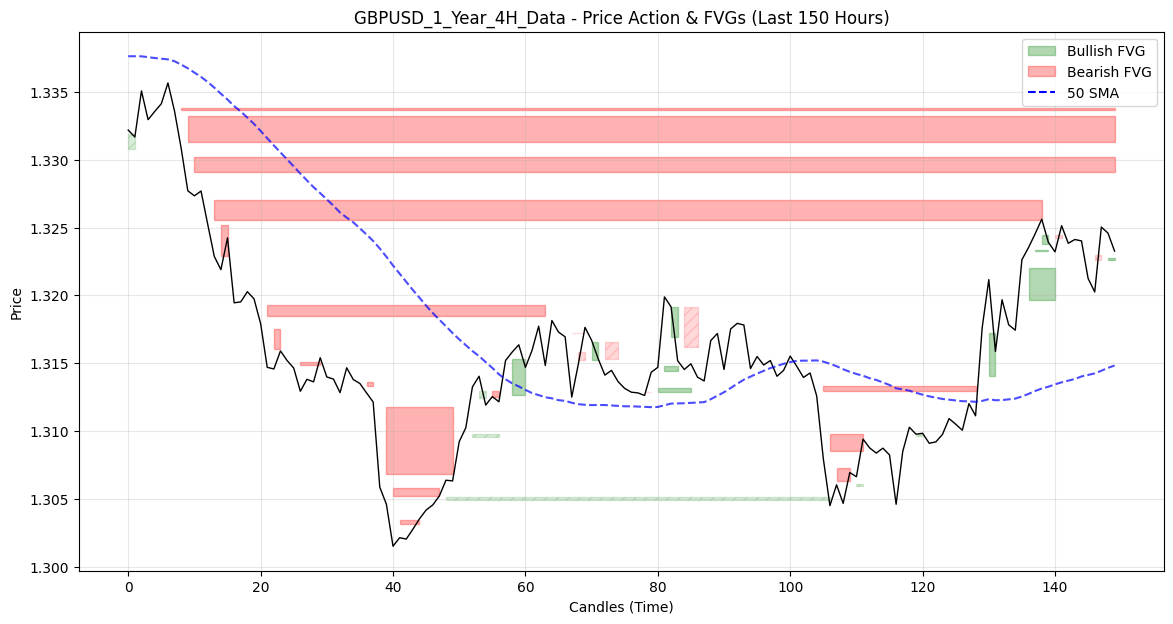

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os  # added to handle file paths and names dynamically


# enter the file path to be analyzed here.
# make sure this is an Excel file (.xlsx)
# when you change this, all output files and titles will update automatically.
FILE_PATH = 'GBPUSD_1_Year_4H_Data.xlsx'
SMA_PERIOD = 50  # Moving Average period to define "Trend Continuation"

def check_mitigation(fvg_type, gap_top, gap_bottom, future_data):
    """
    checking if an FVG is mitigated by future price action.
    returns (True, mitigation_time) if mitigated, else (False, None).
    """
    for _, row in future_data.iterrows():
        if fvg_type == 'Bullish':
            # bullish FVG (Support): price is above. mitigated if Low drops into gap.
            if row['low'] <= gap_top:
                return True, row['datetime']

        elif fvg_type == 'Bearish':
            # bearish FVG (Resistance): price is below. mitigated if High rises into gap.
            if row['high'] >= gap_bottom:
                return True, row['datetime']

    return False, None

def plot_fvgs(df, fvgs, file_name, num_candles=150):
    """
    plotting the last 'num_candles' of price data with FVG rectangles overlayed.
    uses 'file_name' to dynamically name the chart title and output file.
    """
    print(f"\n--- Generating Plot for last {num_candles} candles ---")

    # slice the data for better visibility (plotting 6 months is too compclicated)
    subset = df.tail(num_candles).copy()
    subset = subset.reset_index(drop=True)

    fig, ax = plt.subplots(figsize=(14, 7))

    # plot Close Price
    ax.plot(subset.index, subset['close'], color='black', label='Close Price', linewidth=1)

    # plot SMA (Trend Line) if it exists in the subset
    if 'sma' in subset.columns:
        ax.plot(subset.index, subset['sma'], color='blue', label=f'{SMA_PERIOD} SMA (Trend)', linestyle='--', alpha=0.7)


    date_to_idx = {date: idx for idx, date in enumerate(subset['datetime'])}

    # plot FVGs
    for fvg in fvgs:
        # only plot if the FVG start time is visible in our current subset
        if fvg['datetime'] in date_to_idx:
            start_idx = date_to_idx[fvg['datetime']]

            # determine end index (mitigation time or end of chart)
            if fvg['mitigated'] and fvg['mitigation_time'] in date_to_idx:
                end_idx = date_to_idx[fvg['mitigation_time']]
            else:
                end_idx = subset.index[-1] # extend to end of chart if not mitigated (or mitigated in future)

            width = max(1, end_idx - start_idx) # ensure at least 1 width

            # determine color based on trend context
            # lighter/solid for continuation, darker/hatched for counter-trend
            if fvg['context'] == 'Trend Continuation':
                alpha_val = 0.3
                hatch_style = None
            else:
                alpha_val = 0.15
                hatch_style = '///'

            # draw rectangle
            # xy is the bottom-left corner.
            if fvg['type'] == 'Bullish':
                rect = mpatches.Rectangle(
                    (start_idx, fvg['gap_bottom']),
                    width,
                    fvg['gap_size'],
                    alpha=alpha_val,
                    color='green',
                    hatch=hatch_style
                )
                ax.add_patch(rect)

            elif fvg['type'] == 'Bearish':
                rect = mpatches.Rectangle(
                    (start_idx, fvg['gap_bottom']),
                    width,
                    fvg['gap_size'],
                    alpha=alpha_val,
                    color='red',
                    hatch=hatch_style
                )
                ax.add_patch(rect)

    # formatting: Dynamic Title based on file name
    ax.set_title(f"{file_name} - Price Action & FVGs (Last {num_candles} Hours)")
    ax.set_xlabel("Candles (Time)")
    ax.set_ylabel("Price")
    ax.grid(True, alpha=0.3)

    # custom legend
    green_patch = mpatches.Patch(color='green', alpha=0.3, label='Bullish FVG')
    red_patch = mpatches.Patch(color='red', alpha=0.3, label='Bearish FVG')
    sma_line = plt.Line2D([0], [0], color='blue', linestyle='--', label=f'{SMA_PERIOD} SMA')
    ax.legend(handles=[green_patch, red_patch, sma_line])

    # save and show: Dynamic Filename
    output_img = f'{file_name}_chart.png'
    plt.savefig(output_img)
    print(f"Chart saved to {output_img}")
    plt.show()

def analyze_gbpusd_data(file_path):
    print("--- loading and cleaning data ---")

    # extract the base name of the file (e.g., 'GBPUSD_Data' from 'path/to/GBPUSD_Data.xlsx')
    # this will be used for naming output files dynamically.
    base_name = os.path.splitext(os.path.basename(file_path))[0]

    try:
        # load the dataset
        df = pd.read_excel(file_path, header=0)
    except FileNotFoundError:
        print(f"error: The file '{file_path}' was not found. please check the file path.")
        return
    except Exception as e:
        print(f"error reading Excel file: {e}")
        return

    # clean the dataframe: Drop the first two rows (metadata garbage)
    df = df.iloc[2:].reset_index(drop=True)

    # rename columns
    df.columns = ['datetime', 'close', 'high', 'low', 'open']

    # convert types
    df['datetime'] = pd.to_datetime(df['datetime'])
    cols_to_numeric = ['open', 'high', 'low', 'close']
    for col in cols_to_numeric:
        df[col] = pd.to_numeric(df[col])

    print(f"data successfully loaded from '{base_name}'. Total rows: {len(df)}")


    # PART 0: calculate Indicators (Trend)

    # calculate Simple Moving Average
    df['sma'] = df['close'].rolling(window=SMA_PERIOD).mean()
    print(f"Calculated {SMA_PERIOD}-period SMA for Trend detection.")
    print("-" * 30)


    # PART 1: detailed Statistics

    print(f"\n--- Detailed Price Statistics ({base_name}) ---")

    # calculate stats using describe() and transpose for better reading
    stats = df[cols_to_numeric].describe().T[['mean', 'std', 'min', '50%', 'max']]
    stats.rename(columns={'50%': 'median'}, inplace=True)

    # formatting for display
    print(stats.round(5))


    # PART 2: detect Fair Value Gaps (FVG) & Mitigation

    print("\n--- Detecting Fair Value Gaps & Trend Context ---")
    print("Scanning")

    df['prev_2_high'] = df['high'].shift(2)
    df['prev_2_low'] = df['low'].shift(2)

    fvgs = []

    for i in range(2, len(df)):
        current_row = df.iloc[i]
        prev_2_high = df.iloc[i-2]['high']
        prev_2_low = df.iloc[i-2]['low']

        # get Trend Context (SMA) at this specific time
        # if price is above SMA -> Uptrend, else Downtrend
        current_sma = current_row['sma']
        trend_status = "Neutral" # default if SMA is NaN (start of data)

        if not pd.isna(current_sma):
            if current_row['close'] > current_sma:
                trend_status = "Uptrend"
            else:
                trend_status = "Downtrend"

        fvg_data = None

        # check Bullish FVG
        if current_row['low'] > prev_2_high:
            fvg_context = "Counter-Trend / Reversal"
            if trend_status == "Uptrend":
                fvg_context = "Trend Continuation"

            fvg_data = {
                'datetime': current_row['datetime'],
                'type': 'Bullish',
                'gap_top': current_row['low'],
                'gap_bottom': prev_2_high,
                'gap_size': current_row['low'] - prev_2_high,
                'mitigated': False,
                'mitigation_time': None,
                'trend_at_creation': trend_status,
                'context': fvg_context
            }

        # check Bearish FVG
        elif current_row['high'] < prev_2_low:
            fvg_context = "Counter-Trend / Reversal"
            if trend_status == "Downtrend":
                fvg_context = "Trend Continuation"

            fvg_data = {
                'datetime': current_row['datetime'],
                'type': 'Bearish',
                'gap_top': prev_2_low,
                'gap_bottom': current_row['high'],
                'gap_size': prev_2_low - current_row['high'],
                'mitigated': False,
                'mitigation_time': None,
                'trend_at_creation': trend_status,
                'context': fvg_context
            }

        # if an FVG was found, check for mitigation
        if fvg_data:
            future_data = df.iloc[i+1:]
            is_mitigated, mit_time = check_mitigation(
                fvg_data['type'],
                fvg_data['gap_top'],
                fvg_data['gap_bottom'],
                future_data
            )
            fvg_data['mitigated'] = is_mitigated
            fvg_data['mitigation_time'] = mit_time
            fvgs.append(fvg_data)

    # results
    fvg_df = pd.DataFrame(fvgs)

    if not fvg_df.empty:
        total = len(fvg_df)
        continuation = len(fvg_df[fvg_df['context'] == 'Trend Continuation'])
        counter = len(fvg_df[fvg_df['context'] == 'Counter-Trend / Reversal'])

        print(f"Total FVGs detected: {total}")
        print(f"Trend Continuation FVGs: {continuation} ({(continuation/total)*100:.1f}%)")
        print(f"Counter-Trend FVGs:      {counter} ({(counter/total)*100:.1f}%)")

        # save to CSV using dynamic filename
        output_filename = f'{base_name}_detailed_fvgs.csv'
        fvg_df.to_csv(output_filename, index=False)
        print(f"\nDetailed FVG list (with trend context) saved to: {output_filename}")


        # PART 3: Visualization

        # Pass base_name to the plotting function
        plot_fvgs(df, fvgs, base_name, num_candles=150)

    else:
        print("No Fair Value Gaps detected.")

if __name__ == "__main__":
    analyze_gbpusd_data(FILE_PATH)

##3. Summary


The goal of this EDA was to determine if Fair Value Gaps (FVGs) act as reliable "magnets" or "launchpads" for trend continuation, or if they are merely random price movements. We tested the hypothesis across multiple currency pairs (GBPUSD, EURUSD, USDJPY) and timeframes (30M, 1H, 4H).

The data shows that FVGs are not made up by random. They represent areas of market imbalances that the price aims to respect. By filtering out these gaps with a Simple Moving Average, we identified a statistically important trading edge that persists across different market conditions.
69% of the FVGs showed a behaviour that moving with the trend continuation, while 31% of the FVGs showed an opposite behaviour which moves against the trend continuation. These values can be diversified with using the other data sets for different currency pairs ( USD/JPY, EUR/USD, eg.)

